In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [3]:
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

train_path = './dataset/train/' # path containing training image samples

In [4]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0) # Covid
        elif folder.name[0]=='V':
            y_train.append(1) # Viral Pneumonia
        else:
            y_train.append(2) # Normal

In [5]:
X_train = np.array(X_train)
X_train.shape # We have 251 training samples in total

(251, 256, 256, 3)

In [6]:
y_train = np.array(y_train)
y_train.shape

(251,)

## Visualizing the Dataset

<BarContainer object of 3 artists>

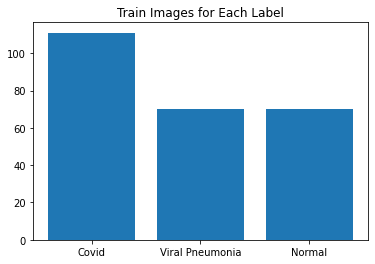

In [7]:
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more number of covid samples than Pneumonia and Normal

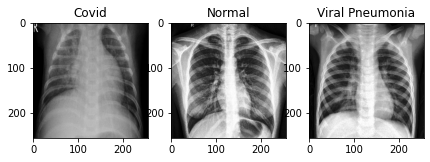

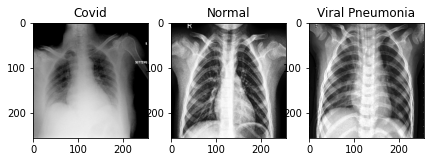

In [8]:
# Plotting 2 images per disease

import random

title = {0:"Covid", 1:"Viral Pneumonia", 2:"Normal"}

rows = 2
columns = 3

for i in range(2):
    
    fig = plt.figure(figsize=(7,7))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+pneumonia_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 3)
    pos = random.randint(covid_count+pneumonia_count, covid_count+pneumonia_count+normal_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])

## Image Augmentation
Augmentation is the process of creating new training samples by altering the available data. <br>
It not only increases the number of samples for training the model but also prevents the model from overfitting the training data since it makes relevant feautes in the image location invariant. <br>
Although there are various ways of doing so like random zoom, increasing/decreasing brightness, rotating the images, most of it does not make sense for Health related data as the real world data is almost always of high quality. <br>
So we only applied one type of Image Augmentation in this Model : <b> Horizontal Flip </b>. <br>
Now, even if we try to classify horizontaly flipped images, we can expect to get correct predictions.

Text(0.5, 1.0, 'Original Image')

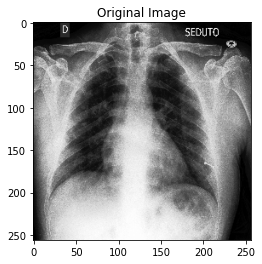

In [9]:
plt.imshow(X_train[0])
plt.title("Original Image")

Text(0.5, 1.0, 'Horizontaly Flipped Image')

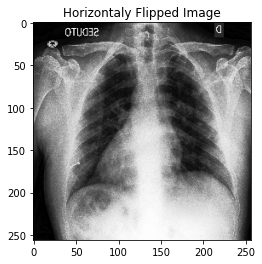

In [10]:
X_new = np.fliplr(X_train[0])
plt.imshow(X_new)
plt.title("Horizontaly Flipped Image")

In [11]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

In [12]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [13]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(502, 256, 256, 3)

In [14]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape
# Now we have 502 samples in total

(502,)

## Spliting the data for Training and Validation

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train)

In [17]:
# we will use 426 images for training the model
y_train.shape

(426,)

In [19]:
# we will use 76 images for validating the model's performance
y_val.shape

(76,)

## Designing and Training the Model

In [20]:
# Get the ResNet50 base model
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [21]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [22]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [23]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [25]:
# Slowing down the learning rate
opt = optimizers.Adam(learning_rate=0.0001)

In [26]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [27]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="covid_classifier_weights.h5", verbose=1, save_best_only=True)

In [28]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=16, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7441
Epoch 00001: val_loss improved from inf to 0.17930, saving model to covid_classifier_weights.h5
27/27 [==============================] - 15s 550ms/step - loss: 0.6731 - accuracy: 0.7441 - val_loss: 0.1793 - val_accuracy: 0.9079
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9014
Epoch 00002: val_loss improved from 0.17930 to 0.13939, saving model to covid_classifier_weights.h5
27/27 [==============================] - 11s 415ms/step - loss: 0.2303 - accuracy: 0.9014 - val_loss: 0.1394 - val_accuracy: 0.9605
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9718
Epoch 00003: val_loss improved from 0.13939 to 0.08518, saving model to covid_classifier_weights.h5
27/27 [==============================] - 11s 415ms/step - loss: 0.0867 - accuracy: 0.9718 - val_loss: 0.0852 - val_accuracy: 0.9737
Epoch 4/100
27/27 [====

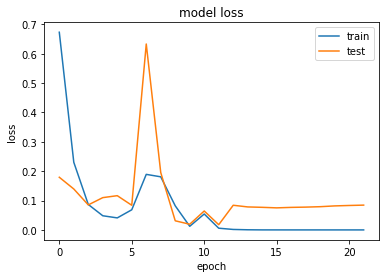

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

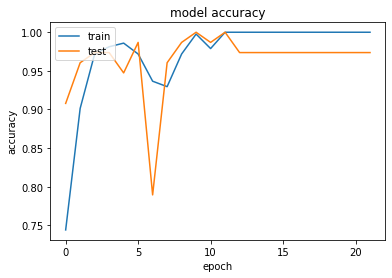

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [32]:
# Load pretrained model (best saved one)
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

### Loading the Test Images

In [33]:
X_test = [] # To store test images
y_test = [] # To store test labels

test_path = './dataset/test/'

for folder in os.scandir(test_path):
    for entry in os.scandir(test_path + folder.name):

        X_test.append(read_and_preprocess(test_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='V':
            y_test.append(1)
        else:
            y_test.append(2)
            
X_test = np.array(X_test)
y_test = np.array(y_test)

In [34]:
X_test.shape # We have 66 images for testing

(66, 256, 256, 3)

<BarContainer object of 3 artists>

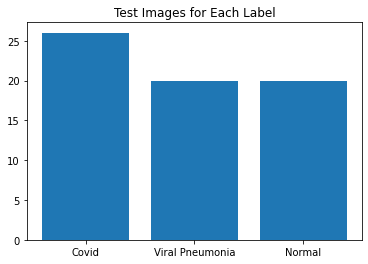

In [35]:
covid_count = len(y_test[y_test==0])
pneumonia_count = len(y_test[y_test==1])
normal_count = len(y_test[y_test==2])

plt.title("Test Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more number of covid samples than Pneumonia and Normal in test dataset as well

In [36]:
# making predictions
predictions = model.predict(X_test)

In [37]:
predictions.shape

(66, 3)

In [38]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [39]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.9696969696969697

<AxesSubplot:>

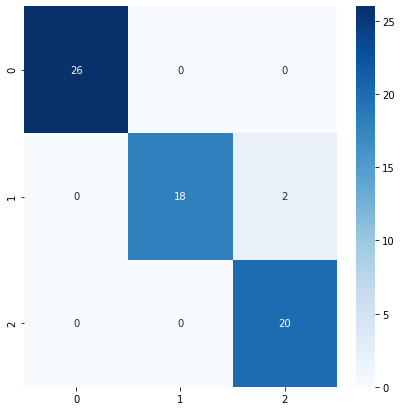

In [40]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

# The model misclassified two Pneumonia cases as Normal

In [41]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.90      0.95        20
           2       0.91      1.00      0.95        20

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66

